# Spectra Fitting with Emcee

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.io import fits
from astropy.table import Table
import emcee
from scipy.interpolate import Akima1DInterpolator
from scipy.optimize import curve_fit
import seaborn as sb

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 15

In this notebook we will expand upon the line fitting tools you have acquired in part 1 and expand upn them by using a new tool called emcee. Emcee is a python package that does paramter estimation in a Bayesian way. The advantage to this approach is that you will be able to not only get the best fit values on your paramters but also the corresponding uncertainties. The downside to this approach is that you will be responsible with: 

1. Cleaning the data
2. Generating the Model
3. Computing the likelihood functions
4. Coming up with any priors for your parameters
4. Executing emcee

But fear not we will go over these steps in the following cells in this notebook.

# 1. Cleaning the data

One of the first things we have to do is to ensure that the data we are working with is in a good condition to perform scientific analysis. While a lot of work has been done to ensure that the data you are working with is as good as possible there can be edge cases or something along the data reduction pipeline that did not work properly. One of the things you can do is to do some descriptive analysis such as finding the minimum, maximum, mean, median, standard deviation, and plotting the data with simple plots or histograms to get a sense of how the data is distributed. So let us do this with the following file:

In [2]:
#reading in the file

# Open the FITS file
file = fits.open("hlsp_ceers_jwst_nirspec_nirspec4-004315_comb-mgrat_v0.7_x1d-masked.fits")

# Access the data within the first HDU (assuming the table is in the first HDU)
data = file[1].data

# Get the column names
column_names = data.columns.names

# Print the column names
for name in column_names:
    print(name)


WAVELENGTH
FLUX
FLUX_ERROR
FLUX_VAR_POISSON
FLUX_VAR_RNOISE
FLUX_VAR_FLAT
SURF_BRIGHT
SB_ERROR
SB_VAR_POISSON
SB_VAR_RNOISE
SB_VAR_FLAT
DQ
BACKGROUND
BKGD_ERROR
BKGD_VAR_POISSON
BKGD_VAR_RNOISE
BKGD_VAR_FLAT
NPIXELS


In [17]:
#getting the flux, flux error and wavelength
flux = data['FLUX']
flux_error = data['FLUX_ERROR']
wavelength = data['WAVELENGTH']

Now let us check out the data and see what we are working with with some descriptive statistics and basic plotting.

In [18]:
max_flux = np.amax(flux)
min_flux = np.amax(flux)

min_ferr = np.amin(flux_error) 
max_ferr = np.amax(flux_error) 

min_wave = np.amin(wavelength)
max_wave = np.amax(wavelength)

print(f'Minimum flux: {min_flux}')
print(f'Maximum flux: {max_flux}')
print(f'Minimum flux error: {min_ferr}')
print(f'Maximum flux error: {max_ferr}')
print(f'Minimum wavelength: {min_wave}')
print(f'Maximum wavelength: {max_wave}')



Minimum flux: nan
Maximum flux: nan
Minimum flux error: nan
Maximum flux error: nan
Minimum wavelength: 0.9621973332627215
Maximum wavelength: 5.2853083458237275


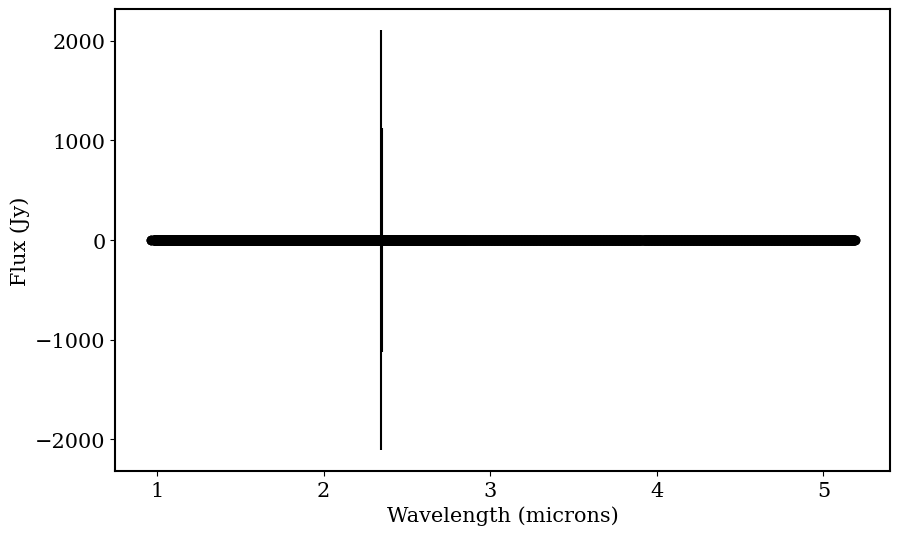

In [19]:
#plotting up the data
plt.figure(figsize=(10,6))
plt.step(wavelength, flux, color='black', where = 'mid', label='Flux')
plt.errorbar(wavelength, flux, yerr=flux_error, fmt='o', color='black', label='Flux Error')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (Jy)')
plt.show()

Hmm, looks like we have some NaN values and the spectra looks odd with some large errors. In order for us to do analysis we need a way to get rid of these pesky NaN values that could be causing the large spikes that we see in the spectrum above. Luckily for us numpy has so nifty functions to detect NaNs and we can use these to mask them out. Let us do that below:

In [20]:
#we had some nan values so we get a nan mask and apply the mask to the data
#np.isnan is a function that returns True if the value is nan and False if it is not
#~ is a not operator so it will return True if the value is not nan and False if it is nan
flux_nan = ~np.isnan(flux)
flux_error_nan = ~np.isnan(flux_error)

#combining the two masks
master_mask = flux_nan & flux_error_nan

#applied mask to the data
wavelength_cleaned = wavelength[master_mask]
flux_cleaned = flux[master_mask]
flux_error_cleaned = flux_error[master_mask]

In [22]:
max_flux = np.amax(flux_cleaned)
min_flux = np.amax(flux_cleaned)

min_ferr = np.amin(flux_error_cleaned) 
max_ferr = np.amax(flux_error_cleaned) 

min_wave = np.amin(wavelength_cleaned)
max_wave = np.amax(wavelength_cleaned)

print(f'Minimum flux: {min_flux}')
print(f'Maximum flux: {max_flux}')
print(f'Minimum flux error: {min_ferr}')
print(f'Maximum flux error: {max_ferr}')
print(f'Minimum wavelength: {min_wave}')
print(f'Maximum wavelength: {max_wave}')



Minimum flux: 2.334903765558588e-05
Maximum flux: 2.334903765558588e-05
Minimum flux error: 6.507835168954218e-08
Maximum flux error: 2106.951913983271
Minimum wavelength: 0.9813597824098755
Maximum wavelength: 5.189999166878419


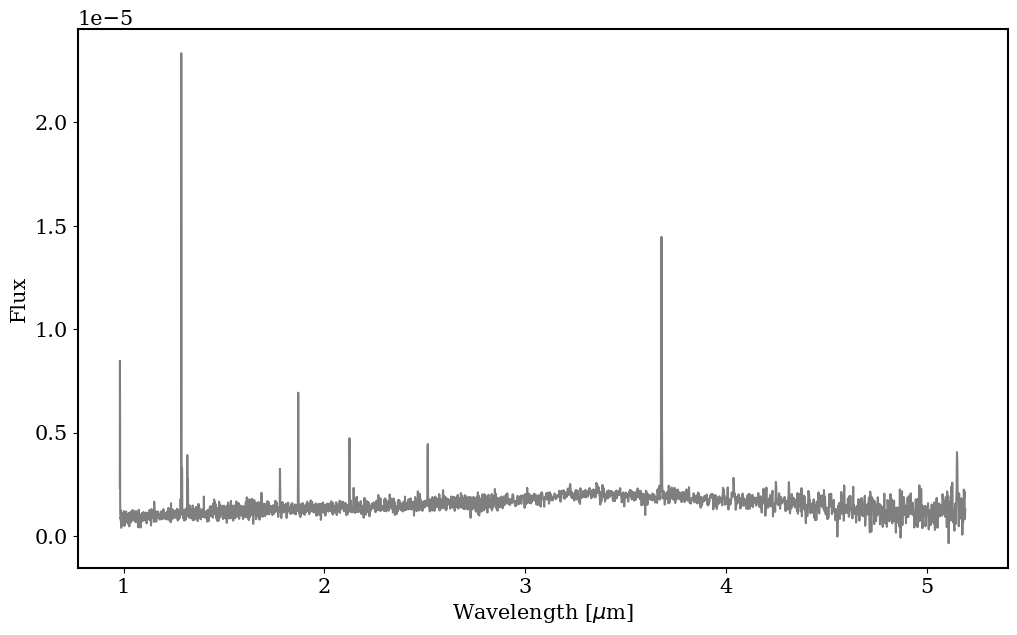

In [21]:
#plotting the Spectrum
plt.figure(figsize = (12, 7))

plt.plot(wavelength_cleaned, flux_cleaned, color = 'black', alpha = 0.5)

plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel('Flux')
plt.show()

Look at that!! The spectrum looks really nice and by removing the NaNs we were able to see it and get some descriptive statistics from the spectrum! Now that we have the spectrum we can go ahead to step 2 of Emcee fitting

# 2 Model Generation

When fitting a single line the model you will be using is going to be a combination of a Gaussian and a line. The gaussian will fit the shape of the emission line and the line will fit any continuum offset near the emission line. So let us define our models separatey and then merge them together.

In [5]:
def gaussian(x, A, mu, sigma):
    
    '''
    Gaussian Model for Line Fitting. This is of the form:
    
    Gaussian = Ae^(-(x-mu)^2/sigma^2)
    
    Input
    -------------
    x: array or single value to evaluate the Gaussian 
    A: amplitude of the Gaussian
    mu: Center of the Gaussian
    sigma: the standard deviation of the Gaussian
    
    
    Returns
    --------------
    Evaluated Gaussian for the given A, mu and sigma at the point(s) in x
    
    '''
    
    return A * np.exp(-(x - mu)**2/ (sigma**2))

def line(x, b):
    
    '''
    Continuum of the spectra using y = b
    
    Input
    ------------
    x: array of values
    b: value to plot y = b
    
    
    Returns
    ------------
    An array of values at b, the same size as x
    
    '''
    
    return  np.ones(len(x))*b

def line_model(x, A, mu, sigma, b):
    
    '''
    Emission Line model using Gaussian and the continuum
    
    Inputs
    ------------

    x: array of values to evaluate the Gaussian 
    A: amplitude of the Gaussian
    mu: Center of the Gaussian
    sigma: the standard deviation of the Gaussian
    b: value to plot y = b
    '''
    
    
    return gaussian(x, A, mu, sigma) + line(x, b)

# 3 Making the Likelihood Function

For the likelihood function most of the time what we are trying to improve is how close the model can reproduce our data. This means that we are trying to minimize the difference between the data and model for a certain set of parameters. The likelihood function encapsulates this and we have provided you with a likelihood function below that does this. Please study the inputs and understand what each line of code is doing as a good understanding of this function can help with debugging and interpret results later on.

In [23]:
def log_likelihood(theta, x, y, yerr):
    '''
    This is the likelihood function we are using for emcee to run
    
    This likelihood function is the maximum likelihood assuming gaussian errors.
    
    '''
    ################

    #In the context of emcee theta is a tuple that has all the parameters we are trying to fit
    #In this case theta = (A, mu, sigma, m, b)
    
    #in python there is a quick way to pass in a tuple of variables into a function using the * operator
    #so if theta = (A, mu, sigma, m, b) then *theta is the same as passing in A, mu, sigma, m, b
    #into the function line_model without having to write line_model(x, A, mu, sigma, m, b)

    #Making the model of the emission line
    model = line_model(x, *theta)
    
    #To compute the log likelihood we use the formula:
    # summation of (y - model)^2/sigma^2, where y is the data, model is the model for the current paramters theta 
    # and sigma is the error in the data

    #getting the log likelihood, this is similar to chi2 = sum((data - model)^2/sigma^2)
    lnL = -0.5 * np.sum((y - model) ** 2 / yerr**2)
    
    return lnL

# Generating Priors on our Parameters

Now that we have a way to let emcee know if the current set of paramters is a good fit for the data by minimizing the difference between data and model we can now go ahead and work on our priors. Priors are just bounds that we can impose on our parameters. Having a prior is completely optional but it can help with removing unwanted characteristics in the fitting or having it explore values you know it cannot be true. For example, we are fitting emission lines which means that the amplitude for the gaussians will never be negative so you can have a prior to force the amplitude of the gaussian to always be positive. If you have some other prior knowledge on some other parameters then the log_prior function is where you would put those bounds in.

In [ ]:
def log_prior(theta, wave_center, Amp_max):
    '''
    The prior function to be used against the parameters to impose certain criteria for the fitting making 
    sure that they do not go and explore weird values
    
    '''
    #Theta values that goes into our emission line Model
    A, mu, sigma, b = theta
    
    #In this example we have some prior knowledge about the wavelength we are fitting and how much they can vary
    #so this is why in this  prior we are only letting the central wavelength mu vary between a certain range

    #the left most bound and right most bound that the central wavelength can vary
    left_mu = wave_center - .002  # this is how much mu can vary
    right_mu = wave_center + .002 # this is how much mu can vary
    
    #This is imposing a prior on the amplitude of the emission line
    #min and max amplitude of the emission line
    min_A = 0
    max_A = Amp_max * 2
    
    #We also have a prior on the sigma or width of the emission line as it cannot be too small or too big so 
    #this prior takes this into account for this NIRSpec data. If you are working with different data
    #all the priors will need to be updated
    sigma_window_left = .0001 #had to change these for the input spectra these are left bounds for sigma
    sigma_window_right = .005 #had to change these for the input spectra these are right bounds for sigma

    #This is a prior on the continuum of the spectra
    min_cont = 0
        
    if (min_A < A < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > min_cont):
        return 0.0
    else:
        return -np.inf

# 4 Merging the Likelihood and Priors Together

In [ ]:
def log_probability(theta, x, y, yerr, first_wave, Amp_max):
    
    lp = log_prior(theta, first_wave, Amp_max)
    if not np.isfinite(lp):
        #print('Probability is infinite')
        return -np.inf
    prob = lp + log_likelihood(theta, x, y, yerr)
    #print(f'Prob:{prob:.3E}')
    return prob

# Input Values
Now that we have the infrastructure of emcee set we just have one more thing to do. Emcee does require an intial guess to start exploring the parameter space. While you can give it any starting point and, in theory, it should be able to converge at some point this may not be the most optimal strategy. We can try to provide emcee with some good intial guesses and then have emcee be more efficient when it explores the parameter space. So wht we are going to do in the next cell is create a function that can take in a region around the emission line and provide good intial guesses for emcee to use.

In [ ]:
def initial_fits(wave, spectrum, err_spec, window, line_center, diagnose = False):
    
    '''
    This function does an initial fit on the data using curve fit which we then pass in those parameters into emcee
    to do the full MCMC fit later
    
    Inputs
    -------------
    wave: Wavelength Array
    spectrum: Full spectrum array
    err_spec: the Error spectra
    window: the window to look around an emission line in units of the wavelength array
    line_center: The line center of the emission line
    
    Returns:
    
    result: The output of the intial curve fit which would be an array with output in order of the parameters
            in the model np.array([A, mu, sigma, b])
    
    '''

    #the range where the optimization can look between 
    min_window = line_center - window
    max_window = line_center + window
    
    #getting emission line near the line center
    #line_center +/- window
    indx = np.where((min_window < wave) & ((wave < max_window)))[0]

    spec_window = spectrum[indx]
    wave_window = wave[indx]
    err_spec_window = err_spec[indx]
    
    #initial guesses for the optimization
    guess_A = np.amax(spectrum[indx])
    guess_mu = line_center
    
    #We interpolate the spectrum near the emission line, we do this to get an estimate on sigma by computing 
    #the full width at half-maximum
    spec_interp = Akima1DInterpolator(wave_window, spec_window)
    
    #making a wavelength array near the emission line
    x = np.linspace(wave_window[0], wave_window[-1], 10000)
    
    #applying the wavelength array to the interpolated function
    spec = spec_interp(x)
    
    #getting the value at half maximum
    half_max = np.amax(spec)/2
    
    #finding index where the spectrum is higher than the half-maximum value
    #the first and last indexes are the wavelength where the sigma can be computed
    idx = np.where(spec > half_max)[0]
    
    #getting the left and right most wavelengths
    wave_left, wave_right = x[idx[0]], x[idx[-1]]
    
    #taking the difference between the right and left wavelength and divide it by 2 to get a guess for the sigma
    guess_sigma = (wave_right - wave_left)/2

    guess_b = np.median(spec_window)
    
    if diagnose == True:
        
        print('Minimization Guesses')
        print(f"A: {guess_A}")
        print(f"mu: {guess_mu}")
        print(f"sigma: {guess_sigma}")
        print(f"b: {guess_b}")
        print() 

    #making initial guesses
    x0 = [guess_A, guess_mu, guess_sigma, guess_b]

    #making lower and upper bounds to use into curve_fit
    low_bounds = [0, min_window, 0, guess_b/2]
    high_bounds = [2*guess_A, max_window, .005, guess_b*2]
    #the above code is similar to the log_prior function but for curve_fit where we tell curve_fit to only look between
    #these bounds

    # Optimization of the initial gaussian fit
    result,_ = curve_fit(line_model, #the function we are fitting
                         wave_window, #the x array
                         spec_window, #the y array
                         p0 = x0,     #the initial guesses
                        bounds = [low_bounds, high_bounds])                 
    
    
    ########
    # Diagnostic Plotting: making sure we are getting the emission line
    ########
    if diagnose == True:
        
        print('Minimization Results')
        print(f"A: {result[0]}")
        print(f"mu: {result[1]}")
        print(f"sigma: {result[2]}")
        print(f"b: {result[3]}")
        print()
        
        xarr = np.linspace(wave_window[0], wave_window[-1], 100)
        plt.figure()
        plt.plot(wave_window, spec_window, color = 'blue', label = 'Data')
        plt.scatter(wave_window, spec_window, color = 'blue')
        plt.plot(xarr, line_model(xarr, *result), color = 'black', label = 'Model')
        plt.axhline(0, linestyle = '--')
        plt.ylabel('Flux')
        plt.xlabel(r'Wavelength $\mu$m')
        plt.title('Initial curve_fit Fitting')
        plt.legend()
        plt.show()
    
    
    return result

# 5 Using Emcee

Emcee is a fully Bayesian way to fit a model to a data. The steps involved for using emcee is to define three functions:

1. log_prior: This is a function that holds any prior conditions on the parameters you are trying to fit
2. log_likelihood: This is a function that tells emcee how likely the current parameters are at recreating the data
3. log_probability: This is the summation of log_prior and log_likelihood and gives the probability of that
                    This is something that we want to maximize as we want the sets of parameters to give us the 
                    most probability


Which we covered in the above cells. Now that we have all the pieces in place we can now go ahead and run emcee on the spectrum.

The way emcee works is that we need to generate what are called "walkers". These walkers explore the parameter space and they use the log_likelihood and log_prior to test if the parameter they are exploring is a good one or a bad one. They use the output of log_prior and log_likelihood to walk towards the parameters where the model is the best fit to the data. Then due to MCMC at some point the walkers should converge and once they have converged you can use those parameters after the walkers have converged. Let us see that in action in the function below.
                    
                    

In [6]:
def fitting_line(wave, flux, flux_err, line_center, window_wavelength, run = 3000,
                 diagnose = False,save_df=True,
                 filename = 'Emcee_Chains_Galaxy.txt'):
    
    '''
    The code that fits the line using the emcee approach
    
    Inputs
    -----------
    wave: Wavelength array
    flux: Flux array
    flux_err: Flux error array
    line_center: the line center
    window_wavelength: The window near emission line in units of wavelength
    run: how many iterations to run emcee on default is 3000
    diagnose: An optional argument to output diagnostic plots as the fitting is proceeding
              Outputs plots from the initial fits, walker locations prior to using emcee and output emcee plots
    save_df: Saving the emcee df output to a file
    save_spec: Saving spectra used in emcee fitting to a file
    file_spec: name of the file for the emcee spectra
    filename:The name of the file to save the emcee output
    
    Returns
    -----------
    emcee_wave: The wavelength array used in the emcee fitting 
    emcee_spec: the flux spectra array used in the emcee fitting
    emcee_err: The error array used in the emcee fitting 
    emcee_df: the output emcee data frame with parameter values and flux estimates using Flux = A*sigma*sqrt(2 pi)
    '''
    
    
    #calling the function that does the initial fitting
    result = initial_fits(wave, flux, flux_err, window_wavelength, line_center, diagnose = diagnose)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_mu = result[1]
    guess_sigma = result[2]
    guess_b = result[3]
    
    ############################################################################################################################
    #The code below is generating walkers for every single parameter we are trying to fit
    #The walkers are generated by taking a normal distribution centered on the best fit value from the curve_fit
    #The scale of the normal distribution is tailored to the parameter we are fitting
    #each of the jump parameters are then reshaped into a column vector and stacked horizontally to make the starting walkers
    ############################################################################################################################

    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from curve_fit
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from curve_fit
                                       scale = .005,      #can wander +/- 0.005 microns (again tailored to nirspec
                                       size = 32).reshape(-1, 1)#data so if you are working with other spectra 
                                                                #you may need ot update this)
    
    sigma_jump = np.random.normal(loc = guess_sigma,       #centered on best sigma from curve_fit
                                  scale = .002,            #can wander +/- 0.002 microns (tailored for nirspec data)
                                  size = 32).reshape(-1, 1)

    
    #getting the power of 10 that the linear fit is
    powerb = np.log10(guess_b)
    
    #
    b_jump = np.random.normal(loc = guess_b,           #centered on best b from curve_fit
                              scale = 1*10**powerb,    #making it wander 10^powerb (if b = .05, it can wander .01)
                              size = 32).reshape(-1, 1)

    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump)
        ax[0, 0].set_xlabel('Amplitude')
        
        ax[0, 1].hist(wavelength_jump)
        ax[0, 1].set_xlabel(r'$\mu$')
        
        ax[1, 0].hist(sigma_jump)
        ax[1, 0].set_xlabel(r'$\sigma$')
        
        ax[1, 1].hist(b_jump)
        ax[1, 1].set_xlabel('b')
        
        plt.show()
    

    #stacking along the columns and generating the starting walkers
    starting_walkers = np.hstack((amp_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength 
    
    #getting indexes near the emission line based off of the emcee_window
    #looking at line_center +/- emcee_window
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0] 

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]


    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, #giving emcee the walker positions
                                    ndim,     #giving it the dimension of the model(same as number of model parameters)
                                    log_probability, #giving it the log_probability function
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A), #arguments to pass into log_probability
                                    )

    #running emcee for 1000 iterations
    state = sampler.run_mcmc(pos, 1000)
    #We then reset the sample as the first 1000 iterations are the burn-in 
    sampler.reset()
    #we then run emcee for the desired number of iterations
    sampler.run_mcmc(state, run, progress=False)

    #getting values back
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[:, 0]
    emcee_df['mu'] = flat_samples[:, 1]
    emcee_df['sigma'] = flat_samples[:, 2]
    emcee_df['b'] = flat_samples[:, 3]
    emcee_df['LnL'] = LnL_chain[:]
    
    #removing values where the log_likelihood was infinite as these are bad fits
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    
    #getting the flux from the parameter values
    fluxes_emcee = emcee_df['A'] * emcee_df['sigma'] * np.sqrt(2 * np.pi)
    
    emcee_df['Fluxes'] = fluxes_emcee
    
    if diagnose == True:
        
        print('Checking Prameter Posterior Distributions')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        emcee_df.A.hist(ax = ax[0, 0])
        emcee_df.mu.hist(ax = ax[0, 1])
        emcee_df.sigma.hist(ax = ax[1, 0])
        #emcee_df.m.hist(ax = ax[1, 0])
        emcee_df.b.hist(ax = ax[1, 1])
        
        plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save_df == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return emcee_wave, emcee_spec, emcee_err, emcee_df


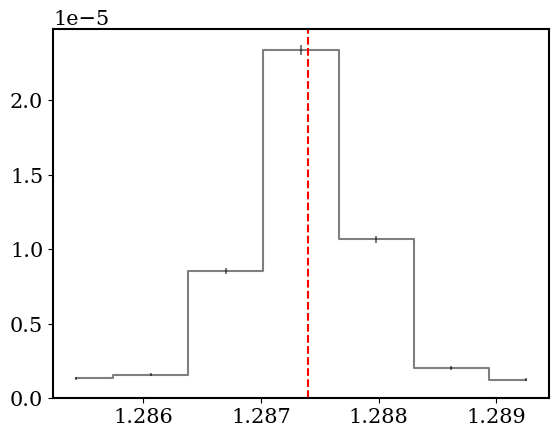

In [16]:
line_window = .002

#best fit lambda
best_lamba_obs = 1.2874

mask = (wavelength_cleaned > best_lamba_obs - line_window) & (wavelength_cleaned < best_lamba_obs + line_window)

plt.figure()
plt.step(wavelength_cleaned[mask], flux_cleaned[mask], where = 'mid', color = 'black', alpha = 0.5)
plt.errorbar(wavelength_cleaned[mask], flux_cleaned[mask], yerr = flux_error_cleaned[mask], fmt = 'none', color = 'black', alpha = 0.5)
plt.axvline(best_lamba_obs, color = 'red', linestyle = '--')
plt.show()

In [14]:

#we perform the fitting on this line
check_wave, check_flux, check_flux_err, check_df = fitting_line(wavelength_cleaned, 
                                                                flux_cleaned, flux_error_cleaned, 
                                                                best_lamba_obs, line_window, save_df = False,
                                                                diagnose = False)

/Users/oac466/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [15]:
cobaltblue = '#2e37fe'

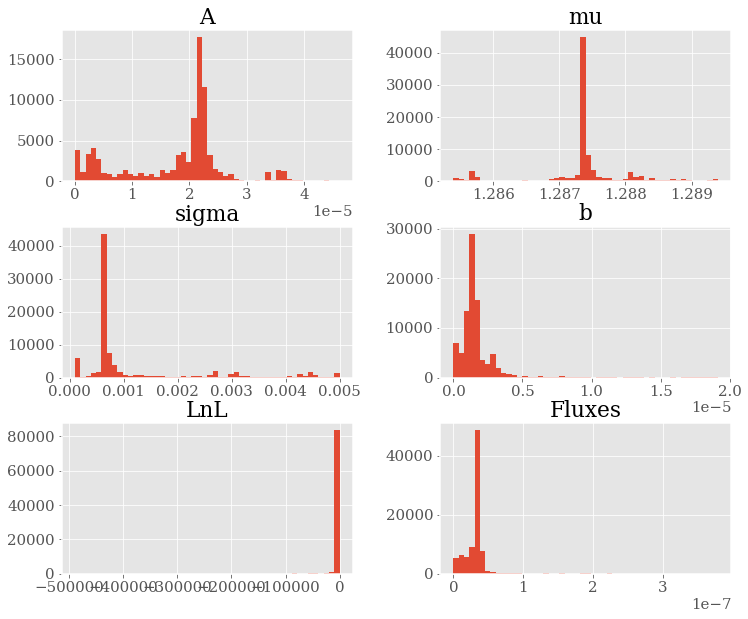

In [28]:
#checking the histograms of the posterior distributions on our parameters
check_df.hist(figsize = (12, 10), bins = 50)
plt.show()

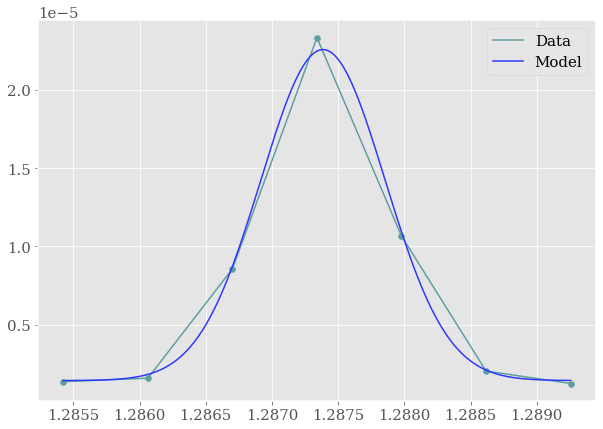

In [18]:
#making a wavelength array from the emcee wavelength array
xarr = np.linspace(check_wave[0], check_wave[-1], 1000)

#Getting the median parameters from the emcee fit
median_param_vals = check_df.quantile(q = 0.5).values[:-2] #We use the [:-2] because the last two columns 
                                                           #are LnL and Flux
                                                           #We do not need those for the line_model 

plt.figure(figsize = (10, 7))
plt.step(check_wave, check_flux, where = 'mid', color = 'cadetblue', label = 'Data')
plt.errorbar(check_wave, check_flux, yerr = check_flux_err, fmt = 'o', color = 'cadetblue')
plt.plot(xarr, line_model(xarr, *median_param_vals), label = 'Model', color = cobaltblue)
plt.legend()
plt.show()